In [9]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random

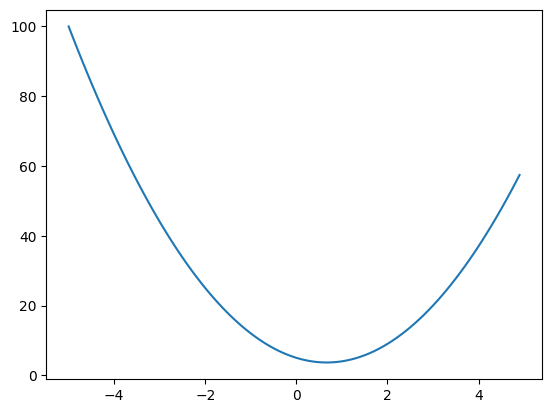

In [2]:
f = lambda x: 3*x**2 - 4*x + 5

x = np.arange(-5, 5, 0.1)
y = f(x)

plt.plot(x, y)
plt.show()

In [17]:
a = 3
h = 1e-5
f(a), f(a + h)

(20, 20.0001400003)

In [19]:
f_prime = lambda x: 6*x - 4
y = f_prime(a)
y_prox = (f(a + h) - f(a)) / h
y, y_prox, y - y_prox

(14, 14.00003000000538, -3.0000005379449135e-05)

In [60]:
a = 2.0
b = -3.0
c = 10.0

d = a * b + c
d

4.0

* Since b is negative, by adding a small value to a, we are subtracting a small value from d.
* The rate of change of d with respect to a is proportional to the value that multiplies a which is b
* So d derivative with respect to a is negative dd / da, more precisely, its derivative is -3 (b)
* dd / da = b

In [62]:
a = 2.0
b = -3.0
c = 10.0

h = 1e-5
d1 = a * b + c
a += h  # adding a small value to a
d2 = a * b + c
d1, d2, (d2 - d1) / h

(4.0, 3.9999699999999994, -3.000000000064062)

* Here we have the opposite, since a is positive, by adding a small value to b, we are adding a small value to d.
* The rate of change of d with respect to b is proportional to the value it multiplies (a)
* So d derivative with respect to b is positive, more precisely, its derivative is 2 (a)

In [63]:
h = 1e-5

a = 2.0
b = -3.0
c = 10.0

d1 = a * b + c
b += h
d2 = a * b + c
d1, d2, (d2 - d1) / h

(4.0, 4.00002, 2.0000000000131024)

* Here we have the same as before, by adding a small value to c, we are adding a small value to d.
* The amount of change in d is the same as the amount of change in c.
* So d derivative with respect to c is positive, more precisely, its derivative (slope or rate of change) is 1

In [64]:
h = 1e-5

a = 2.0
b = -3.0
c = 10.0

d1 = a * b + c
c += h
d2 = a * b + c
d1, d2, (d2 - d1) / h

(4.0, 4.00001, 0.9999999999621422)

In [1]:
class Value:
    def __init__(self, data, _prev = (), _op = '', label = ''):
        self.data = data
        self.label = label
        self._backward = lambda: None
        self.grad = 0.0
        self._prev = set(_prev)
        self._op = _op

    def __repr__(self):
        return f"Value(value={self.data})"

    def __add__(self, other):
        """
        This function is called when we use the + operator to add two values.
        a = b + c
        * a is out, b is self and c is other
        * self grad and other grad are the current grads + out grad
        * + flows the gradient through the graph, since the rate of change is constant
        """
        other = other if isinstance(other, Value) else Value(other)
        out = Value(data=self.data + other.data, _prev=(self, other), _op='+')
        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        """
        This function is called when we use the * operator to multiply two values.
        a = b * c
        * a is out, b is self and c is other
        * self grad are the current grads + other.data * out.grad
        * other grad are the current grads + self.data * out.grad
        * * scales the gradient based on the value of the other element of the multiplication
        * Since the rate of change is the same as the value of the other element of the multiplication, we can think of it as a percentage of the other element
        """
        other = other if isinstance(other, Value) else Value(other)
        out = Value(data=self.data * other.data, _prev=(self, other), _op='*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(data=self.data ** other, _prev=(self, ), _op='**')
        def _backward():
            self.grad += (other * self.data ** (other - 1.)) * out.grad
        out._backward = _backward
        return out
    
    def __radd__(self, other):
        return self + other
    
    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        return self * other ** -1
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(data=t, _prev=(self, ), _op='tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), _prev=(self, ), _op='exp')
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
        
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')

e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
f"{L.data}"
        

'-8.0'

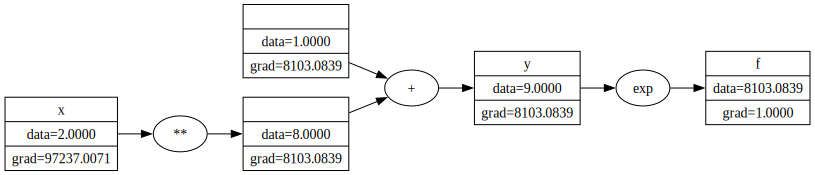

In [10]:
y = Value(2.0, label='x') ** 3 + 1; y.label = 'y'
f = y.exp(); f.label = 'f'
f.backward()
draw_dot(f)


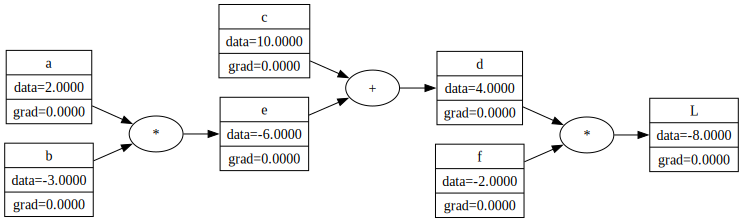

In [3]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

nodes, edges = trace(d)

def draw_dot(root):
    dot = Digraph(comment='Computation Graph', format='svg', graph_attr={'rankdir': 'LR'})
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label="%s | data=%.4f | grad=%.4f" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=uid+n._op, label=n._op)
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot
draw_dot(L)



Backpropagation is a recursive application of the chain rule over the graph, calculating the "local" gradient of each node and then propagating it to the previous nodes.

* L = d * f
  * dL / dd = f = -2
  * dL / df = d = 4
* d = e + c
  * dd / de = 1
  * dd / dc = 1
* e = a * b
  * de / da = b = -3
  * de / db = a = 2

--------------------------------

### dL/dd -> dL/dc = dL/dd * dd/dc
### dL/dd -> dL/de = dL/dd * dd/de

* L = d * f
* d = e + c
* L = (e + c) * f
  * dL / dc = dL / dd * dd / dc = -2
  * dL / de = dL / dd * dd / de = -2
    * dd / dc = 1
    * dd / de = 1

--------------------------------

### dL/dd -> dL/de -> dL/da = dL/de * de/da = (dL/dd * dd/de) * de/da
### dL/dd -> dL/de -> dL/db = dL/de * de/db = (dL/dd * dd/de) * de/db

* L = (e + c) * f
* L = (a * b + c) * f
  * dL / da = dL / de * de / da = 6
  * dL / db = dL / de * de / db = -4
    * de / da = b = -3
    * de / db = a = 2



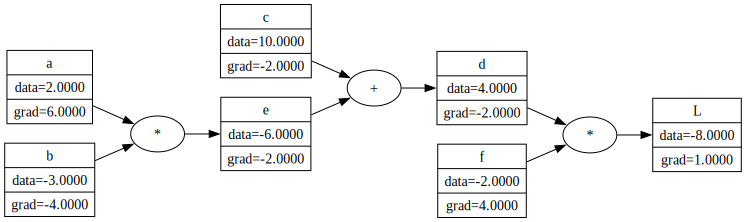

In [11]:
L.backward()
draw_dot(L)

Now that you understand how backpropagation works, we can see how we can use it to influence the value of the leaf node (L).
In the example below, we are increasing the value of each node by a fraction of its gradient (ie going in the direction of the gradient), resulting in an increase in the value of L.
So L was -8 and now it's...

In [17]:
L.backward()

In [18]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
d.data += 0.01 * d.grad
e.data += 0.01 * e.grad
f.data += 0.01 * f.grad

e = a*b
d = e + c
L = d * f
L.data

-7.286496

In [19]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.881373587019543, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

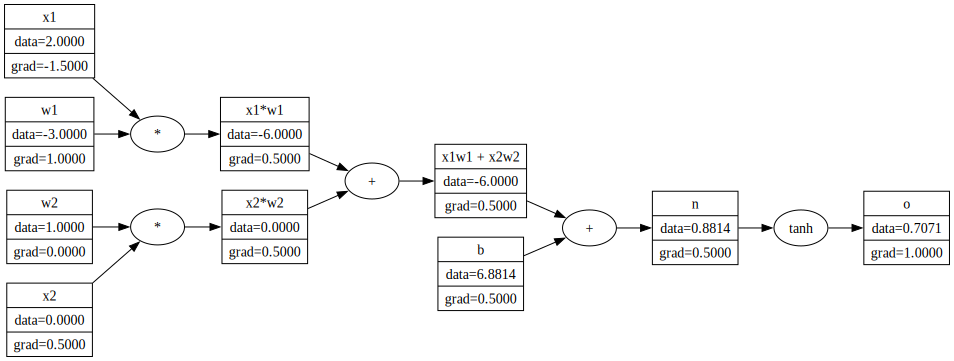

In [20]:
draw_dot(o)

In [21]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.881373587019543, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

e = (2 * n).exp(); e.label = 'e'
o = (e - 1) / (e + 1); o.label = 'o'

o.backward()

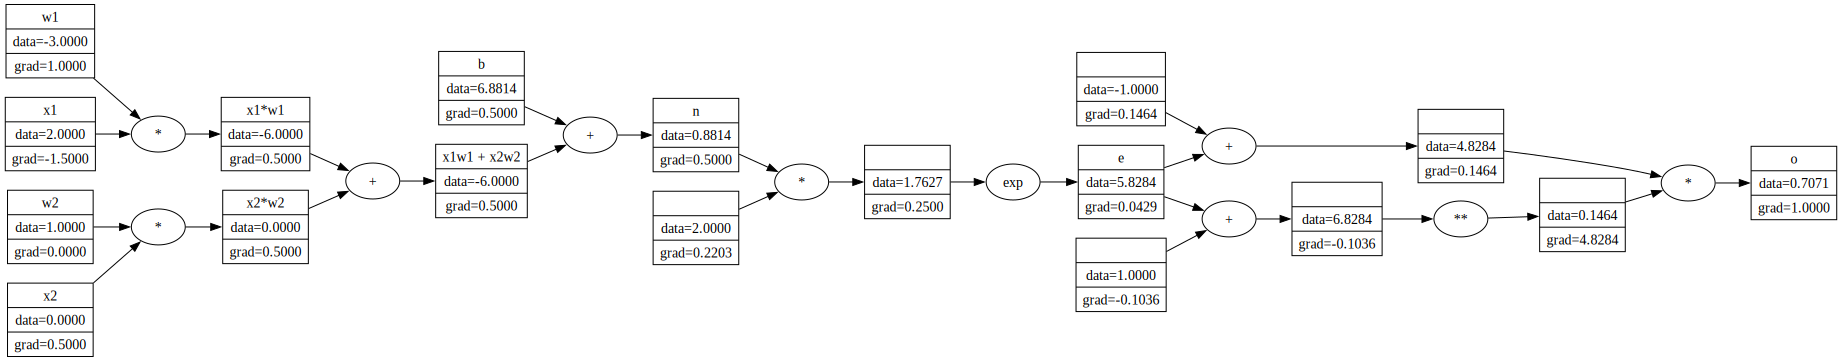

In [22]:
draw_dot(o)


In [275]:
import torch

x1 = torch.tensor(2.0, requires_grad=True)
x2 = torch.tensor(0.0, requires_grad=True)
w1 = torch.tensor(-3.0, requires_grad=True)
w2 = torch.tensor(1.0, requires_grad=True)
b = torch.tensor(6.881373587019543, requires_grad=True)

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.item())
o.backward()

print(x1.grad.item(), x2.grad.item(), w1.grad.item(), w2.grad.item(), b.grad.item())


0.7071067094802856
-1.5000003576278687 0.5000001192092896 1.000000238418579 0.0 0.5000001192092896


In [27]:
class Neuron:
    def __init__(self, number_of_inputs):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(number_of_inputs)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        act = sum((_w * _x for _w, _x in zip(self.w, x)), self.b)
        return act.tanh()

    def __len__(self):
        return len(self.w)

    def parameters(self):
        return self.w + [self.b]

n = Neuron(2)
o = n([2.0, 3.0])
print(f"{o=}")
print(f"{n.parameters()=}")

o=Value(value=-0.5950566881044282)
n.parameters()=[Value(value=0.7809076301825184), Value(value=-0.5763565807342428), Value(value=-0.5182042526808874)]


* [i_11, i_12]

* l_1
  * w_11
  * w_12
    * o_1 = w_11 * i_11 + w_12 * i_12
  * w_21
  * w_22
    * o_2 = w_21 * i_11 + w_22 * i_12
  * w_31
  * w_32
    * o_3 = w_31 * i_11 + w_32 * i_12


In [30]:
class Layer:
    def __init__(self, number_of_inputs, number_of_outputs):
        self.neurons = [Neuron(number_of_inputs) for _ in range(number_of_outputs)]

    def __call__(self, x):
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out

    def size(self):
        return (len(self.neurons[0], len(self.neurons)))

    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]

l = Layer(2, 3)
o = l([2.0, 3.0])
print(f"{o=}")
print(f"{l.size()=}")
print(f"{l.parameters()=}")

o=[Value(value=-0.9991173097492392), Value(value=0.5490392309723102), Value(value=0.9946870664867914)]
l.size()=(2, 3)
l.parameters()=[Value(value=-0.28033774561046965), Value(value=-0.9467183509843247), Value(value=-0.46179043022893795), Value(value=0.7678088942746939), Value(value=0.010154658775632486), Value(value=-0.9490768560481082), Value(value=0.8744958671568408), Value(value=0.4962476607800099), Value(value=-0.2736855542992658)]


In [33]:
class MLP:
    def __init__(self, number_of_inputs, number_of_outputs):
        sz = [number_of_inputs] + number_of_outputs
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(number_of_outputs))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def size(self):
        return tuple(layer.size() for layer in self.layers)

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

m = MLP(3, [4, 4, 1])
print(f"{m.size()=}")

m.size()=((3, 4), (4, 4), (4, 1))


In [384]:
xs = [
    [2.0, 3.0, -1],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0]
ypred = [m(x) for x in xs]
ypred

[Value(value=-0.3896009364556052),
 Value(value=-0.42546466848826653),
 Value(value=-0.4460085475314101),
 Value(value=-0.43364354315015835)]

In [396]:
for k in range(20):
    ypred = [m(x) for x in xs]
    loss = sum((y_pred - y_true) ** 2 for y_true, y_pred in zip(ys, ypred))
    for p in m.parameters():
        p.grad = 0.0
    loss.backward()
    for p in m.parameters():
        p.data += -0.1 * p.grad
    print(k, loss)


0 Value(value=0.00520471846481149)
1 Value(value=0.005098051595866143)
2 Value(value=0.004995561670493721)
3 Value(value=0.004897010272321859)
4 Value(value=0.004802176706182009)
5 Value(value=0.004710856386342799)
6 Value(value=0.0046228593971752675)
7 Value(value=0.004538009205134435)
8 Value(value=0.004456141503843386)
9 Value(value=0.004377103176526044)
10 Value(value=0.004300751362128657)
11 Value(value=0.004226952613255721)
12 Value(value=0.004155582135572906)
13 Value(value=0.004086523099640867)
14 Value(value=0.004019666017269105)
15 Value(value=0.003954908175451055)
16 Value(value=0.0038921531217804037)
17 Value(value=0.003831310195975273)
18 Value(value=0.0037722941027680205)
19 Value(value=0.0037150245219671183)


In [397]:
ypred

[Value(value=0.9633359336808694),
 Value(value=-0.9773053452769376),
 Value(value=-0.9644349897748432),
 Value(value=0.9756925225990234)]